# PREDICTIVE MAINTAINANCE

## Introduction
I was involved in a chat recently on the possibility of using data to predict machine maintainance. It led to several days of me thinking of all possible ways to solve the problem. Some of the questions I asked myself included; What type of data do I need to answer the problem I am trying to solve?, Where do I get that data?

After several days of searching through the web (including the newly released Google Dataset Search engine), I found the SECOM dataset on UCI's Machine Learning Repository.



## About the dataset
The data is a 1567x591 matrix collected from a semi-conductor manufacturing process. Below is a brief description of the dataset taken from the website.

`A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process.`

You can find the dataset and other relevant documents here https://archive.ics.uci.edu/ml/datasets/SECOM

Why this dataset you ask?

Well my hypothesis is that, certain signals in the data are significant in determining if process will fail or pass. Each signal will be considered as a feature, which will be used to train a model.

Here we go...

In [1]:
import pandas as pd
import numpy as np

In [2]:
#import dataset
data = np.genfromtxt('data\secom.data')

#dataset shape
data.shape

(1567, 590)

In [3]:
#import data label
data_label = np.genfromtxt('data\secom_labels.data')

#dataset label shape
data_label.shape #1567 rows and 3 columns

(1567, 3)

### Data Pre-processing

In [4]:
#check for missing values 

print('Number of columns with missing values:' , np.sum(np.isnan(data).any(axis = 0)))

print('Number of rows with missing values:' , np.sum(np.isnan(data).any(axis = 1)))

print('Number of missing values in dataset:', np.sum(np.isnan(data)),'(', "%.2f" % (np.sum(np.isnan(data))/(data.shape[0]*data.shape[1])*100),
      '% of the dataset)')

Number of columns with missing values: 538
Number of rows with missing values: 1567
Number of missing values in dataset: 41951 ( 4.54 % of the dataset)


In [5]:
print('Minimum proportion of missing values in a feature:', '%.2f' % np.min(np.isnan(data).sum(axis = 1)/data.shape[0]))

print('Maximum proportion of missing values in a feature:', '%.2f' % np.max(np.isnan(data).sum(axis = 1)/data.shape[0]))

Minimum proportion of missing values in a feature: 0.00
Maximum proportion of missing values in a feature: 0.10


Only 4.5% of the data is missing and maximum proportion of missing values in a feature is only 10%. All the features of the data have enough information. An obvious approach to fixing the missing values will be to fill them with the relative feature average. 

In [6]:
#check for missing values in data label

print('Number of columns with missing values:' , np.sum(np.isnan(data_label).any(axis = 0)))

print('Number of rows with missing values:' , np.sum(np.isnan(data_label).any(axis = 1)))

Number of columns with missing values: 2
Number of rows with missing values: 1567


All rows the last two columns have missing values. These columns have the datetime stamp of when the monitoring/signal data was collected. These two features are not needed hence they will be ommitted. 

In [7]:
#keep data label only(first column only)
data_label = data_label[:,0]

np.unique(data_label, return_counts = True)

(array([-1.,  1.]), array([1463,  104], dtype=int64))

In [8]:
#Train - Test split
from sklearn.model_selection import train_test_split

X = data.copy()
y = data_label.copy()

#keep 30% of the data for testing the model accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
print('Shape of training data', X_train.shape)
print('Shape of training label', y_train.shape)

print('Shape of test data', X_test.shape)
print('Shape of test label', y_test.shape)

Shape of training data (1096, 590)
Shape of training label (1096,)
Shape of test data (471, 590)
Shape of test label (471,)


In [10]:
#Handling missing values: filling missing values with respective feature average

#calculate the mean of each feature on the data
X_col_mean = np.nanmean(X_train, axis = 0)

#indices of nans in training dataset
X_inds = np.where(np.isnan(X_train))

#fill missing values at indices with column average 
X_train[X_inds] = np.take(X_col_mean, X_inds[1])

In [11]:
#check if training data still have missing values 
np.sum(np.isnan(X_train)) #0 missing values present

0

Now that all missing values have been filled with their repective feature averages, duplicate records(if any) will be removed.

In [12]:
#check for duplicate records in training data
np.unique(X_train, axis = 0).shape[0] #1567 unique rows. 

1096

No duplicated rows/records found in the training data.

### Dimensionality Reduction

There are 590(591 with the data label) features in the data but not all explains or adds value to the data. To reduce the dimension of the data to only features that truly explains the dataset variance, Principal Component analysis (PCA) technique will be used. PCA will identify features with direction of high variance, highlight and keep features of the data that explains close to 100% of the dataset variance. This can also be considered a form of feature engineering/selection process. Another important advantage of reducing the dimension of the data is that, it prevents the model from overfitting to the noise of the training dataset.

But first, scaling the data prevents PCA from being baised to the underlying variance of data feature.

In [13]:
#scaling the data using the StandardScaler library in Sci-kit-learn
from sklearn.preprocessing import StandardScaler

#Instantiate Scaler
scaler = StandardScaler()

#Fit and transform data
X_train_scaled = scaler.fit(X_train).transform(X_train)

#check mean and variance of scaled data
print('Mean of the scaled trainig data:', '%.2f' % np.mean(X_train_scaled))
print('Variance of the scaled trainig data:', '%.2f' % np.var(X_train_scaled))

Mean of the scaled trainig data: 0.00
Variance of the scaled trainig data: 0.79


In [14]:
#dimnsionality reduction using Principal Component Analysis
from sklearn.decomposition import PCA

#Instantiate PCA
pca = PCA() 

#Fit and transform scaled data
X_train_pca = pca.fit(X_train_scaled).transform(X_train_scaled)

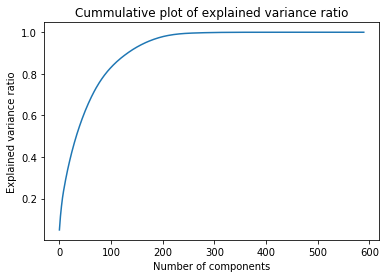

In [15]:
#plot of explained variance
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.title('Cummulative plot of explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

With 250 components, approximately 98% of the data variance is still explained. Hence only these features/signals will be used to train the model.

In [16]:
#dimnsionality reduction using Principal Component Analysis
from sklearn.decomposition import PCA

#Instantiate PCA
pca = PCA(n_components= 250)

#Fit and transform scaled data
X_train_pca = pca.fit(X_train_scaled).transform(X_train_scaled)

In [17]:
X_train_pca.shape

(1096, 250)

### Fitting a Model

Fitting a Logistic Regression model because the expected outcome is binary (-1: pass, 1: fail). The model will then be optimized to see how high of an accuracy can be achieved on predictions without overfitting to the training data.

In [18]:
from warnings import filterwarnings
filterwarnings('ignore')

#Fitting an simple logistic regression model 
from sklearn.linear_model import LogisticRegression

#Instantiate model using default parameters
logreg1 = LogisticRegression()

#Use k=5 cross validation sets
from sklearn.model_selection import cross_val_score

score = cross_val_score(logreg1, X_train_pca, y_train, cv = 5)

print('Average score',np.mean(score))

Average score 0.878654091499385


In [19]:
#Optimizing model's hyperparameters
c_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
val_Score = []

for c in c_range:
    
    #Instantiate model using default parameters
    logreg1 = LogisticRegression(C = c, penalty = 'l2')

    #Use k=5 cross validation sets
    score = cross_val_score(logreg1, X_train_pca, y_train, cv = 5)
    
    #average score 
    val_Score.append(np.mean(score))

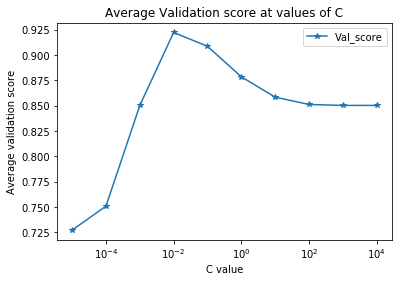

In [20]:
#plotting the validation scores 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

plt.plot(c_range, val_Score, label = 'Val_score', marker = '*')

plt.title('Average Validation score at values of C')
plt.xlabel('C value')
plt.ylabel('Average validation score')

plt.xscale('log')
plt.legend()
plt.show()

The fitted Logistic Regression model is optimized at C = 0.001. 

In [21]:
#Refitting model with best hyperparameters
logreg1 = LogisticRegression(C = 0.001, penalty = 'l2')

In [22]:
#Model Evaluation: Accuracy
logreg1.fit(X_train_pca, y_train).score(X_train_pca, y_train)

0.947992700729927

In [28]:
#Evaluating Model results
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [29]:
#Model Evaluation: Confusion matrix
y_pred = logreg1.predict(X_train_pca)

print('Confusion matrix \n', confusion_matrix(y_train, y_pred)) 

Confusion matrix 
 [[1022   10]
 [  47   17]]


In [30]:
#Model Evaluation: Classification report
print('Classification Report \n', classification_report(y_train, y_pred))

Classification Report 
               precision    recall  f1-score   support

        -1.0       0.96      0.99      0.97      1032
         1.0       0.63      0.27      0.37        64

    accuracy                           0.95      1096
   macro avg       0.79      0.63      0.67      1096
weighted avg       0.94      0.95      0.94      1096



In [36]:
#calculate false and true positive rates at different thresholds
y_pred_prob = logreg1.predict_proba(X_train_pca)[:,1]

fprs, tprs, thresholds = roc_curve(y_train, y_pred_prob, pos_label= 1)

roc_auc = roc_auc_score(y_train, y_pred_prob)

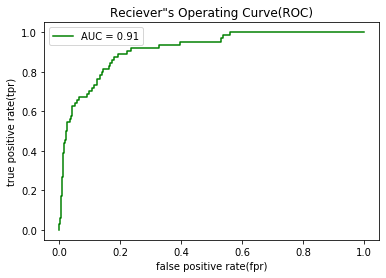

In [37]:
plt.figure()

plt.plot(fprs, tprs,label = 'AUC = ' '%.2f' % roc_auc, color = 'green')

plt.title('Reciever"s Operating Curve(ROC)')
plt.xlabel('false positive rate(fpr)')
plt.ylabel('true positive rate(tpr)')
plt.legend()
plt.show()

The fitted model have a good accuracy of 0.95. However, the confusion matrix and classification report indicates that the model is better at predicting the positive(-1) but not the negative(1) class. This could be because of the data's unbalanced class which can be corrected by oversampling minority class or undersampling the majority class. 

Below is a test to check if different probability threshold will improve the precision and recall of the negative class.

In [38]:
from sklearn.metrics import recall_score, precision_score

#generate random numbers between 0 and 1
threshold = np.linspace(0,1,50)

thresholds = []
fail_class_recall = []
fail_class_precision = []

#predicted probability of class 1(fail)
y_pred_prob = logreg1.predict_proba(X_train_pca)[:,1]

for threshold in threshold:
    
    y_pred = np.where(y_pred_prob > threshold, 1, -1)  #if predicted probability above threshold then classify as pass otherwise fail.
    
    fail_class_recall.append(recall_score(y_train, y_pred))
    
    fail_class_precision.append(precision_score(y_train, y_pred))
    
    thresholds.append(threshold)

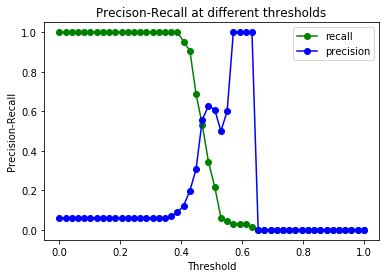

In [39]:
plt.figure()

plt.plot(thresholds, fail_class_recall, marker = 'o', label = 'recall', color = 'green')
plt.plot(thresholds, fail_class_precision, marker = 'o', label = 'precision', color = 'blue')

plt.title('Precison-Recall at different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Precision-Recall')
plt.legend()
plt.show()

In [40]:
#setting up a grid search to find the combination of hyperparameters that could possibly improve the model
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

estimators = [('reduce_dim', PCA()),
              ('model', LogisticRegression())]

params = [{'reduce_dim__n_components': [None, 50, 150, 100, 200, 250]},
             {'model__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]

#Instantiate Pipeline with estimators
pipe = Pipeline(estimators)

#instantiate grid search
grid = GridSearchCV(pipe, param_grid= params, cv = 5)

#Fit to scaled training data
fitted_search = grid.fit(X_train_scaled, y_train)

In [41]:
#best estimator
fitted_search.best_estimator_

Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [42]:
#Accuracy of model on the training set
fitted_search.score(X_train_scaled, y_train)

0.9425182481751825

In [43]:
#Fitting best model from the grid search using a pipeline
estimators = (('reduce_dim',PCA(n_components = 50)),
                  ('model', LogisticRegression(C = 1, penalty = 'l2')))

grid_best_model = Pipeline(estimators)

In [44]:
#fit to training data
grid_best_model.fit(X_train_scaled, y_train)

#Predict y
y_pred = grid_best_model.predict(X_train_scaled)

In [45]:
print('Confusion matrix \n', confusion_matrix(y_train, y_pred))

Confusion matrix 
 [[1032    0]
 [  62    2]]


In [46]:
print('Classification Report \n', classification_report(y_train, y_pred))

Classification Report 
               precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97      1032
         1.0       1.00      0.03      0.06        64

    accuracy                           0.94      1096
   macro avg       0.97      0.52      0.52      1096
weighted avg       0.95      0.94      0.92      1096



Improved accuracy, but the output of the model still indicates a better prediction of the positive than the negative class.

### Oversampling the data

Oversampling the data to balance the classes in an attempt to improve the model prediction of both classes.

In [47]:
#Oversampling using imbalance-learn library
from imblearn.over_sampling import RandomOverSampler

#instantiate oversampler
ros = RandomOverSampler()

#fit and transform 
X_train_resampled,y_train_resampled = ros.fit_resample(X_train, y_train)

print('Shape of training data resampled:', X_train_resampled.shape)
print('Shape of training target resampled:', y_train_resampled.shape)
print('Class oversampled:', np.unique(y_train_resampled, return_counts = True))

Shape of training data resampled: (2064, 590)
Shape of training target resampled: (2064,)
Class oversampled: (array([-1.,  1.]), array([1032, 1032], dtype=int64))


In [48]:
#Set up new Grid search to find the best model that fits the data

estimators_2 = [('normalize', StandardScaler()),
                ('dim_reduced',PCA()),
                ('model', LogisticRegression())]
                    
pipe_2 = Pipeline(estimators_2)

params = [{'normalize': [None, StandardScaler()]},
            {'dim_reduced__n_components': [None, 50, 100, 150, 200, 250]},
            {'model__C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]

fitted_grid_2 = GridSearchCV(pipe_2, param_grid= params, cv = 10)

In [49]:
#fit to training data to grid
fitted_grid_2.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalize',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('dim_reduced',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                        

In [50]:
fitted_grid_2.best_estimator_

Pipeline(memory=None,
         steps=[('normalize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reduced',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [51]:
#Retrain model using resampled training data 

#Normalize training data
X_train_ros_normalized = StandardScaler().fit_transform(X_train_resampled)

#Reduce data dimension
X_train_ros_pca = PCA().fit_transform(X_train_ros_normalized)

In [52]:
#Fitting the third model
model3 = LogisticRegression(C=100, penalty = 'l2')

model3.fit(X_train_ros_pca, y_train_resampled)

y_pred_3 = model3.predict(X_train_ros_pca)

print('Model3: Confusion Matrix \n', confusion_matrix(y_train_resampled,y_pred_3))

Model3: Confusion Matrix 
 [[1032    0]
 [   0 1032]]


In [53]:
model3.score(X_train_ros_pca,y_train_resampled)

1.0

In [54]:
print('Model3: Classification Report \n', classification_report(y_train_resampled,y_pred_3))

Model3: Classification Report 
               precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      1032
         1.0       1.00      1.00      1.00      1032

    accuracy                           1.00      2064
   macro avg       1.00      1.00      1.00      2064
weighted avg       1.00      1.00      1.00      2064



Improved accuracy with oversampled, but overfitted to the training data.

### Final Model

Evaluating final model on test data.

In [55]:
#Feel missing values in test data as done with training data

#indices of nans in training dataset
X_inds = np.where(np.isnan(X_test))

#fill missing values at indices with column average 
X_test[X_inds] = np.take(X_col_mean, X_inds[1])

In [56]:
#Model1:Trained on normalized data, 250 dimensions
model1 = LogisticRegression(C = 0.001, penalty = 'l2')
scaler1 = StandardScaler()
pca1 = PCA(n_components= 250)

X_train_normalized1 = scaler1.fit(X_train).transform(X_train)
X_train_pca1 = pca1.fit(X_train_normalized1).transform(X_train_normalized1)

X_test_normalized1 = scaler1.transform(X_test)
X_test_pca1 = pca1.transform(X_test_normalized1)

model1.fit(X_train_pca1, y_train)


#model2: Trained on unscaled data with only 50 dimension
model2 = LogisticRegression(C = 1, penalty = 'l2')
pca2 = PCA(n_components= 50)
X_train_pca2 = pca2.fit(X_train).transform(X_train)
X_test_pca2 = pca2.transform(X_test)

model2.fit(X_train_pca2, y_train)


#model3: Trained on scaled oversampled data with all data dimensions
model3 = LogisticRegression(C=100, penalty = 'l2')

#Oversampled data
X_train_rs,y_train_rs = RandomOverSampler().fit_resample(X_train,y_train) #where rs = resampled

scaler3 = StandardScaler()
X_train_rs_normalized3 = scaler3.fit(X_train_rs).transform(X_train_rs)
X_test_normalized3 = scaler3.transform(X_test)

pca3 = PCA()
X_train_rs_pca3 = pca3.fit(X_train_rs_normalized3).transform(X_train_rs_normalized3)
X_test_pca3 = pca3.transform(X_test_normalized3)

model3.fit(X_train_rs_pca3, y_train_rs)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
print(f'Model 1: Train Score {"%.2f" % model1.score(X_train_pca1, y_train)}, Test Score {"%.2f" % model1.score(X_test_pca1,y_test)}')
print(f'Model 2: Train Score {"%.2f" % model2.score(X_train_pca2, y_train)}, Test Score {"%.2f" % model2.score(X_test_pca2, y_test)}')
print(f'Model 3: Train Score {"%.2f" % model3.score(X_train_rs_pca3, y_train_rs)}, Test Score {"%.2f" % model3.score(X_test_pca3, y_test)}')

Model 1: Train Score 0.95, Test Score 0.91
Model 2: Train Score 0.89, Test Score 0.86
Model 3: Train Score 1.00, Test Score 0.85


In [67]:
#model1 coefficient
model1.coef_

array([[ 3.69260260e-03,  8.08313898e-03,  3.45224209e-04,
        -7.21853099e-03,  1.24414247e-02, -1.71949612e-03,
        -1.15226396e-02, -6.43326001e-04,  1.40159672e-02,
         1.42198347e-02, -8.22564865e-03, -3.42870443e-03,
         2.08789415e-02,  4.19101879e-03, -1.24967774e-02,
         5.07405098e-03, -1.01201325e-02, -9.39988561e-03,
         1.62232440e-03, -4.17713073e-03,  6.02534297e-03,
        -6.09495166e-03, -7.49112380e-03,  3.41929053e-03,
         1.71830512e-02,  2.84154058e-03,  1.41948042e-03,
        -2.34257742e-03, -9.16235350e-03,  1.75496285e-03,
        -1.20947871e-03, -7.25152832e-03,  1.58942658e-02,
        -1.68335514e-03, -2.88375307e-03, -5.78918548e-03,
         4.58038949e-03, -7.05770263e-03,  8.37693717e-03,
        -2.34634769e-04,  8.45428863e-03,  3.33048662e-03,
         1.82526392e-02,  2.42115108e-03, -5.64556275e-03,
        -9.66031842e-04,  1.11543842e-03, -3.53253908e-03,
        -8.36388170e-03, -1.21761522e-03,  4.58794842e-0

### Conclusion

The best model of the 3 is model1. It has a better precision and recall score for the negative class. This model still isn't good enough because of its weakeness in classifying the negative class. 

A possible next step is to try different classifiers such as KNN, SVM or an ensemble model to investigate if it'll be predict the negative class.